In [1]:
import json 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import re 
import seaborn as sns

from collections import Counter
from functools import reduce

In [2]:
def rename_column(col: str) -> str:
    """Splitts the column names and removes the case description. Returns only the visualization type and variables."""
    if col.startswith('Rad') or col.startswith('Pat'):
        splitted = col.split('\xa0')
        vis_type = splitted[0].replace(' ', '')
        vis_vars = splitted[-1].translate(str.maketrans({' ': '', '[': '', ']': '', '|': '_'}))
        return '_'.join([vis_type, vis_vars])
    else:
        return col

def convert_data(json: dict) -> pd.DataFrame:
    """Converts the data from json to pandas DataFrame and performs some data wrangling to bring columns into the right format."""
    # convert json to pandas Dataframe
    df = pd.DataFrame.from_dict(json['responses'])
    # drop case description
    df = df.drop(list(df.filter(regex='Imagine you are presented *')), axis=1)
    # rename cols 
    df.columns = df.columns.to_series().apply(rename_column)
    # extract variables (e.g. boring_exciting, ...) (same for all visualization types, e.g. Overlay, Frame, ...)
    vars = list(set(['_'.join(v.split('_')[-2:]) for v in df.filter(regex='Overlay', axis=1).columns]))
    # split data to retrieve ratings for each visualization type 
    melted = []
    for var in vars:
        data = df.copy().filter(regex=f'Res|{var}', axis=1).melt(id_vars='Response ID', var_name='vis_type', value_name=f'{var}').dropna()
        melted.append(data)
    # combine data to get one column for visualization type and one column with ratings for each variable (e.g. Frame, boring_exciting, biasing_neutral, etc.)
    melted = pd.concat(melted, ignore_index=True, sort=False)
    # remove RadiologyUI and PathologyUI from visualization type (what remains is Overlay, Frame, Heatmap, etc. )
    melted.vis_type = melted.vis_type.apply(lambda x: re.split('UI|_', x)[1])
    # extract demographics and other variables
    demos = df.filter(regex='^(?!Rad|Pat)', axis=1)
    # combine variabels with demographics
    comb = demos.merge(melted, on='Response ID', how='left')
    # add identifier 
    comb['Expertise'] = comb['In which field are you active?'].map({'1': 'Radiology', '2': 'Pathology'})
    # change vis_type names
    comb['vis_type'] = comb['vis_type'].map({'Frame': 'Segmentation Contour', 'Framerectangle': 'Bounding Box', 'Heatmap': 'Heatmap', 'Overlay': 'Segmentation Mask'})
    return comb

## Load data

First loading the original survey data. Then cleaning and formatting the data for ease of data handling. 

In [3]:
# set fp
res_file = 'data/limesurvey_master_elias_kwaka_codes.json'

# open json file 
with open(res_file) as f:
    data = json.load(f)

# convert data 
df = convert_data(data)
df.to_csv('results/results_wide.csv', sep=';', index=False)

len(df), len(df.columns)

(1961, 27)

In [4]:
# remove subjects with missing last page
df = df[df['Last page'].notna()]

# remove subjects who did not complete survey
df = df[df['Last page'].astype(int) > 3]

len(df['Response ID'].unique())

24

In [5]:
# collect information about the sample 
info_data = df[['Response ID', 'Expertise', 'How old are you?', 'How many years of experience do you have in your field?', 'What was your favorite option?']].drop_duplicates()
len(info_data)

24

In [6]:
info_data.head()

,Response ID,Expertise,How old are you?,How many years of experience do you have in your field?,What was your favorite option?
0,23,Pathology,2,1,2
60,24,Radiology,3,9,3
121,26,Pathology,3,10,4
304,32,Radiology,3,10,1
365,34,Pathology,4,16,4


### Visualize meta data

In [7]:
age_hash = {
    0: '<20',
    1: '20-29',
    2: '30-39',
    3: '40-49',
    4: '50-59',
    5: '60-69',
    6: '>70'
}

fav_hash = {
    0: 'Segmentation Contour', 
    1: 'Heatmap', 
    2: 'Bounding Box',
    3: 'Segmentation Mask'
}

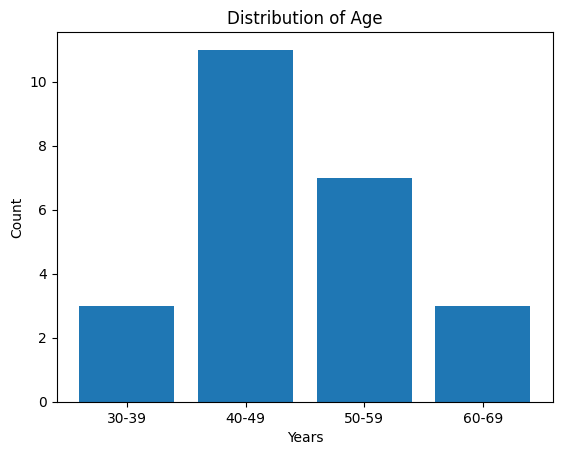

In [8]:
# Visualize age distribution
age_counter = Counter(info_data['How old are you?'])
fig, ax = plt.subplots()
ax.bar([age_hash[int(k)] for k in age_counter.keys()], age_counter.values())
ax.set_title('Distribution of Age')
ax.set_xlabel('Years')
ax.set_ylabel('Count')
plt.show()

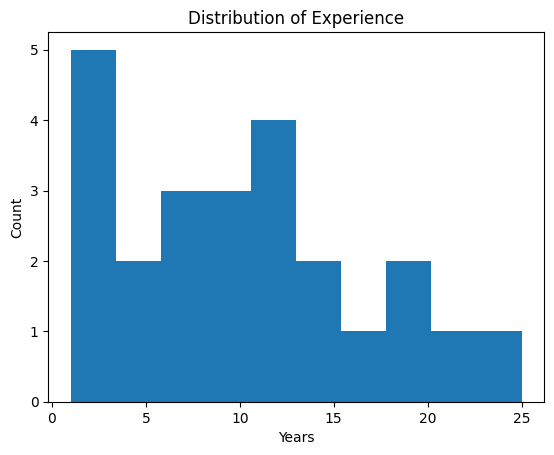

In [9]:
# Visualize experience
fig, ax = plt.subplots()
ax.hist( info_data['How many years of experience do you have in your field?'].astype(int))
ax.set_title('Distribution of Experience')
ax.set_xlabel('Years')
ax.set_ylabel('Count')
plt.show()

## Compute Subscale Scores
Compute the aggregated subscale scores as described in the UEQ-S tool.

In [10]:
ux_hash = {
    'boring_exciting': 'Hedonic Quality',
    'conventional_inventive': 'Hedonic Quality',
    'complicated_easy': 'Pragmatic Quality',
    'usual_leadingedge': 'Hedonic Quality',
    'biasing_neutral': 'Problem-Specific Quality',
    'confusing_clear': 'Pragmatic Quality',
    'inappropriate_sound': 'Problem-Specific Quality',
    'inefficient_efficient': 'Pragmatic Quality',
    'obscure_comprehensible': 'Problem-Specific Quality',
    'doubtful_trustworthy': 'Problem-Specific Quality', 
    'insignificant_meaningful': 'Problem-Specific Quality',
    'notinteresting_interesting': 'Hedonic Quality',
    'untraceable_traceable': 'Problem-Specific Quality',
    'obstructive_supportive': 'Pragmatic Quality',
    'undemonstrative_expressive': 'Problem-Specific Quality'
}

In [11]:
# drop unused scores 
to_drop = ['obscure_comprehensible', 'inappropriate_sound', 'undemonstrative_expressive']

In [12]:
# convert to long format for plotting
df_long  = df.melt(id_vars=['Response ID', 'Expertise', 'vis_type'], value_vars=df.columns[11:-1].tolist())
df_long = df_long.dropna()
df_long['value'] = df_long['value'].astype(int)
df_long['ux_quality'] = df_long['variable'].map(ux_hash)

# drop unused scores 
df_long.drop(df_long[df_long['variable'].apply(lambda x: x in to_drop)].index, inplace=True, axis=0)

# save results 
df_long.to_csv('results/results_long.csv', sep=';', index=False)

In [13]:
# transform the values to be zero centered
df_long = df_long.assign(value_tf = lambda df: df['value']-4)

# compute quality metrics for each user 
df_qualities_long = df_long.groupby(['Response ID', 'ux_quality', 'vis_type'], as_index=False).agg({'value_tf': 'mean'})
df_qualities_long.head(10)

,Response ID,ux_quality,vis_type,value_tf
0,23,Hedonic Quality,Bounding Box,0.25
1,23,Hedonic Quality,Heatmap,2.00
2,23,Hedonic Quality,Segmentation Contour,0.25
3,23,Hedonic Quality,Segmentation Mask,1.50
4,23,Pragmatic Quality,Bounding Box,3.00
5,23,Pragmatic Quality,Heatmap,2.50
6,23,Pragmatic Quality,Segmentation Contour,3.00
7,23,Pragmatic Quality,Segmentation Mask,2.50
8,23,Problem-Specific Quality,Bounding Box,0.00
9,23,Problem-Specific Quality,Heatmap,0.50


In [14]:
len(df_qualities_long)

288

In [15]:
# compute the overall quality metrics for all users 
quality_metrics = df_long.groupby(['ux_quality', 'vis_type'], as_index=False).agg({'value_tf': ['mean', 'var', 'std', 'count']})

# add the overall quality score
overall_quality = df_long.groupby(['vis_type'], as_index=False).agg({'value_tf': ['mean', 'var', 'std', 'count']})
overall_quality['ux_quality'] = 'Overall'
overall_quality = overall_quality[['ux_quality', 'vis_type', 'value_tf']]

# combine results 
all_qualities = pd.concat([quality_metrics, overall_quality], ignore_index=True)
all_qualities

ux_quality              vis_type  value_tf            \
                                                        mean       var   
0            Hedonic Quality          Bounding Box -0.166667  1.571930   
1            Hedonic Quality               Heatmap  1.260417  2.636732   
2            Hedonic Quality  Segmentation Contour  0.854167  1.431140   
3            Hedonic Quality     Segmentation Mask  0.750000  1.536842   
4          Pragmatic Quality          Bounding Box  0.968750  2.304276   
5          Pragmatic Quality               Heatmap  0.635417  4.528838   
6          Pragmatic Quality  Segmentation Contour  1.885417  1.934101   
7          Pragmatic Quality     Segmentation Mask  0.791667  3.135088   
8   Problem-Specific Quality          Bounding Box  0.437500  1.890789   
9   Problem-Specific Quality               Heatmap  0.135417  2.770943   
10  Problem-Specific Quality  Segmentation Contour  0.875000  2.068421   
11  Problem-Specific Quality     Segmentation Mask  0.541667  2.187719   
12                   Overall          Bounding Box  0.413194  2.124843   
13                   Overall               Heatmap  0.677083  3.501633   
14                   Overall  Segmentation Contour  1.204861  2.031056   
15                   Overall     Segmentation Mask  0.694444  2.282617   

                    
         std count  
0   1.253766    96  
1   1.623802    96  
2   1.196303    96  
3   1.239694    96  
4   1.517984    96  
5   2.128107    96  
6   1.390720    96  
7   1.770618    96  
8   1.375060    96  
9   1.664615    96  
10  1.438201    96  
11  1.479094    96  
12  1.457684   288  
13  1.871265   288  
14  1.425151   288  
15  1.510833   288

In [16]:
from scipy.stats import t

# add 95% CI
conf = 0.95
m = all_qualities['value_tf', 'mean']
s = all_qualities['value_tf', 'std']
n = all_qualities['value_tf', 'count']
t_crit = np.abs(t.ppf((1-conf)/2, n))

lower = (m-s*t_crit/np.sqrt(n))
upper = (m+s*t_crit/np.sqrt(n))

all_qualities['CI95_low'] = lower
all_qualities['CI95_high'] = upper
all_qualities.to_csv('results/metrics.csv', sep=';', index=False)

all_qualities

ux_quality              vis_type  value_tf            \
                                                        mean       var   
0            Hedonic Quality          Bounding Box -0.166667  1.571930   
1            Hedonic Quality               Heatmap  1.260417  2.636732   
2            Hedonic Quality  Segmentation Contour  0.854167  1.431140   
3            Hedonic Quality     Segmentation Mask  0.750000  1.536842   
4          Pragmatic Quality          Bounding Box  0.968750  2.304276   
5          Pragmatic Quality               Heatmap  0.635417  4.528838   
6          Pragmatic Quality  Segmentation Contour  1.885417  1.934101   
7          Pragmatic Quality     Segmentation Mask  0.791667  3.135088   
8   Problem-Specific Quality          Bounding Box  0.437500  1.890789   
9   Problem-Specific Quality               Heatmap  0.135417  2.770943   
10  Problem-Specific Quality  Segmentation Contour  0.875000  2.068421   
11  Problem-Specific Quality     Segmentation Mask  0.541667  2.187719   
12                   Overall          Bounding Box  0.413194  2.124843   
13                   Overall               Heatmap  0.677083  3.501633   
14                   Overall  Segmentation Contour  1.204861  2.031056   
15                   Overall     Segmentation Mask  0.694444  2.282617   

                    CI95_low CI95_high  
         std count                      
0   1.253766    96 -0.420669  0.087336  
1   1.623802    96  0.931448  1.589385  
2   1.196303    96  0.611806  1.096528  
3   1.239694    96  0.498848  1.001152  
4   1.517984    96  0.661219  1.276281  
5   2.128107    96  0.204280  1.066553  
6   1.390720    96  1.603669  2.167165  
7   1.770618    96  0.432954  1.150379  
8   1.375060    96  0.158924  0.716076  
9   1.664615    96 -0.201820  0.472654  
10  1.438201    96  0.583633  1.166367  
11  1.479094    96  0.242015  0.841319  
12  1.457684   288  0.244133  0.582256  
13  1.871265   288  0.460055  0.894111  
14  1.425151   288  1.039573  1.370149  
15  1.510833   288  0.519219  0.869670

## Test for statistical differences between visualization types

### Perform repeated measurements ANOVA

In [17]:
import pingouin as pg

# repeated measurements ANOVA 
anova_res = pg.rm_anova(dv='value_tf', within=['ux_quality', 'vis_type'], subject='Response ID', data=df_qualities_long, correction=True)
anova_res

c:\Users\Ammeling\Documents\students\Elias_Kwaka\env\Lib\site-packages\pingouin\distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,ux_quality,16.520833,2,46,8.260417,5.651123,6.389726e-03,0.007545,0.035633,0.940586
1,vis_type,23.667318,3,69,7.889106,2.912505,4.046298e-02,0.060984,0.050273,0.705832
2,ux_quality * vis_type,31.760417,6,138,5.293403,8.306918,1.089606e-07,0.000326,0.066323,0.401660


In [18]:
print(anova_res.to_latex(columns=anova_res.columns, index=False, float_format="%.2f"))

\begin{tabular}{lrrrrrrrrr}
\toprule
               Source &    SS &  ddof1 &  ddof2 &   MS &    F &  p-unc &  p-GG-corr &  ng2 &  eps \\
\midrule
           ux\_quality & 16.52 &      2 &     46 & 8.26 & 5.65 &   0.01 &       0.01 & 0.04 & 0.94 \\
             vis\_type & 23.67 &      3 &     69 & 7.89 & 2.91 &   0.04 &       0.06 & 0.05 & 0.71 \\
ux\_quality * vis\_type & 31.76 &      6 &    138 & 5.29 & 8.31 &   0.00 &       0.00 & 0.07 & 0.40 \\
\bottomrule
\end{tabular}



c:\Temp\ipykernel_24476\1263871571.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(anova_res.to_latex(columns=anova_res.columns, index=False, float_format="%.2f"))


### Perform post-hoc tests
Perform post-hoc test for repeated ANOVA

In [19]:
# pairwise t-test with holm criterion
pw_res = pg.pairwise_tests(dv='value_tf', within=['ux_quality', 'vis_type'], subject='Response ID', return_desc=True, data=df_qualities_long, padjust='holm').round(4)
pw_res.to_csv('results/Posthoc_PairedPairwise_RM_ANOVA.csv', index=False, sep=';')
pw_res

c:\Users\Ammeling\Documents\students\Elias_Kwaka\env\Lib\site-packages\pingouin\pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
c:\Users\Ammeling\Documents\students\Elias_Kwaka\env\Lib\site-packages\pingouin\pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


,Contrast,ux_quality,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,ux_quality,-,Hedonic Quality,Pragmatic Quality,0.6745,0.7767,1.0703,0.9147,True,True,-2.2328,23.0,two-sided,0.0356,0.0712,holm,1.705,-0.4589
1,ux_quality,-,Hedonic Quality,Problem-Specific Quality,0.6745,0.7767,0.4974,0.6577,True,True,1.1579,23.0,two-sided,0.2588,0.2588,holm,0.39,0.2420
2,ux_quality,-,Pragmatic Quality,Problem-Specific Quality,1.0703,0.9147,0.4974,0.6577,True,True,2.9972,23.0,two-sided,0.0064,0.0193,holm,7.028,0.7074
3,vis_type,-,Bounding Box,Heatmap,0.4132,0.9110,0.6771,1.3286,True,True,-0.7117,23.0,two-sided,0.4838,0.9676,holm,0.27,-0.2279
4,vis_type,-,Bounding Box,Segmentation Contour,0.4132,0.9110,1.2049,0.7570,True,True,-3.1151,23.0,two-sided,0.0049,0.0292,holm,8.905,-0.9297
5,vis_type,-,Bounding Box,Segmentation Mask,0.4132,0.9110,0.6944,1.0308,True,True,-1.0457,23.0,two-sided,0.3065,0.9196,holm,0.35,-0.2844
6,vis_type,-,Heatmap,Segmentation Contour,0.6771,1.3286,1.2049,0.7570,True,True,-1.7753,23.0,two-sided,0.0891,0.3563,holm,0.832,-0.4801
7,vis_type,-,Heatmap,Segmentation Mask,0.6771,1.3286,0.6944,1.0308,True,True,-0.0754,23.0,two-sided,0.9405,0.9676,holm,0.215,-0.0144
8,vis_type,-,Segmentation Contour,Segmentation Mask,1.2049,0.7570,0.6944,1.0308,True,True,2.7010,23.0,two-sided,0.0128,0.0638,holm,3.952,0.5552
9,ux_quality * vis_type,Hedonic Quality,Bounding Box,Heatmap,-0.1667,0.9936,1.2604,1.4055,True,True,-4.3130,23.0,two-sided,0.0003,0.0046,holm,116.001,-1.1533


In [20]:
print(pw_res.to_latex(columns=['Contrast', 'ux_quality', 'A', 'B', 'mean(A)', 'std(A)', 'mean(B)', 'std(B)', 'T', 'dof', 'p-unc', 'p-corr'], index=False, float_format="%.2f"))

\begin{tabular}{llllrrrrrrrr}
\toprule
             Contrast &               ux\_quality &                    A &                        B &  mean(A) &  std(A) &  mean(B) &  std(B) &     T &   dof &  p-unc &  p-corr \\
\midrule
           ux\_quality &                        - &      Hedonic Quality &        Pragmatic Quality &     0.67 &    0.78 &     1.07 &    0.91 & -2.23 & 23.00 &   0.04 &    0.07 \\
           ux\_quality &                        - &      Hedonic Quality & Problem-Specific Quality &     0.67 &    0.78 &     0.50 &    0.66 &  1.16 & 23.00 &   0.26 &    0.26 \\
           ux\_quality &                        - &    Pragmatic Quality & Problem-Specific Quality &     1.07 &    0.91 &     0.50 &    0.66 &  3.00 & 23.00 &   0.01 &    0.02 \\
             vis\_type &                        - &         Bounding Box &                  Heatmap &     0.41 &    0.91 &     0.68 &    1.33 & -0.71 & 23.00 &   0.48 &    0.97 \\
             vis\_type &                        - & 

c:\Temp\ipykernel_24476\2135209367.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pw_res.to_latex(columns=['Contrast', 'ux_quality', 'A', 'B', 'mean(A)', 'std(A)', 'mean(B)', 'std(B)', 'T', 'dof', 'p-unc', 'p-corr'], index=False, float_format="%.2f"))


### Check normality assumption

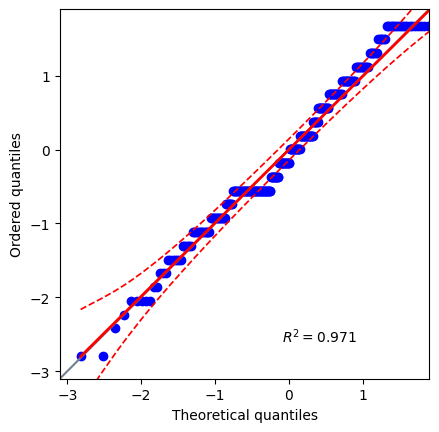

In [21]:
# use qq-plot to check normality of response variable
ax = pg.qqplot(df_qualities_long['value_tf'], dist='norm')
plt.savefig('figures/QQ_Plot_value.png', bbox_inches='tight')
plt.show()


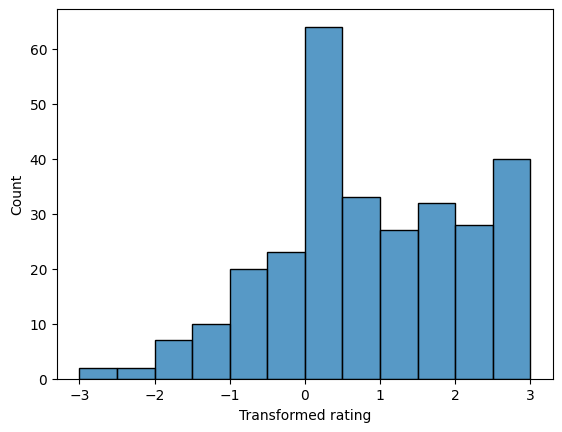

In [22]:
# histogram of residuals
ax = sns.histplot(df_qualities_long['value_tf'])
plt.xlabel('Transformed rating')
plt.savefig('figures/Histogram_value.png', bbox_inches='tight')
plt.show()

In [23]:
# shapiro-wilk test
pg.normality(df_qualities_long['value_tf'])

,W,pval,normal
value_tf,0.9685,0.000006,False


 The figures and shapiro-wilk test indicate a violation to the normality assumption. However, since ANOVA is known to be robust to slight deviations of the normality assumption when the sample size is sufficiently large, we consider our small but balanced sample sufficient and note that we might have problems with statistical power. 

## Compute Cronbach's Alpha for Item Reliability

In [117]:
def cronbachs_alpha(df):
    # transform data and compute correlation matrix 
    corrs = df.assign(value_tf = lambda df: df['value'] - 4).pivot(index=['Response ID'], columns='variable', values='value_tf').corr()
    # get number of items
    n = corrs.shape[0]
    # compute average correlations
    r = corrs.where(np.tril(np.ones(corrs.shape).astype(bool), k=-1)).stack().mean()
    # compute cronbach´s alpha
    return n * r / (1 + (n - 1) * r)

In [118]:
# cronbachs alpha
alphas = []
for ux_qual, vis_type in quality_metrics[['ux_quality' ,'vis_type']].to_numpy():
    items = df_long.query(f'vis_type == "{vis_type}" and ux_quality == "{ux_qual}"')
    alphas += [(ux_qual, vis_type, cronbachs_alpha(items))]

alphas_df = pd.DataFrame(alphas, columns=['ux_quality', 'vis_type', 'alpha'])
alphas_df.to_csv('results/cronbachs_alpha_single.csv', sep=';', index=False)
alphas_df

,ux_quality,vis_type,alpha
0,Hedonic Quality,Bounding Box,0.821303
1,Hedonic Quality,Heatmap,0.879595
2,Hedonic Quality,Segmentation Contour,0.894068
3,Hedonic Quality,Segmentation Mask,0.861582
4,Pragmatic Quality,Bounding Box,0.903600
5,Pragmatic Quality,Heatmap,0.942963
6,Pragmatic Quality,Segmentation Contour,0.845728
7,Pragmatic Quality,Segmentation Mask,0.931715
8,Problem-Specific Quality,Bounding Box,0.776223
9,Problem-Specific Quality,Heatmap,0.805923


In [120]:
print(alphas_df.to_latex(columns=alphas_df.columns, index=False, float_format="%.2f"))

\begin{tabular}{llr}
\toprule
              ux\_quality &             vis\_type &  alpha \\
\midrule
         Hedonic Quality &         Bounding Box &   0.82 \\
         Hedonic Quality &              Heatmap &   0.88 \\
         Hedonic Quality & Segmentation Contour &   0.89 \\
         Hedonic Quality &    Segmentation Mask &   0.86 \\
       Pragmatic Quality &         Bounding Box &   0.90 \\
       Pragmatic Quality &              Heatmap &   0.94 \\
       Pragmatic Quality & Segmentation Contour &   0.85 \\
       Pragmatic Quality &    Segmentation Mask &   0.93 \\
Problem-Specific Quality &         Bounding Box &   0.78 \\
Problem-Specific Quality &              Heatmap &   0.81 \\
Problem-Specific Quality & Segmentation Contour &   0.57 \\
Problem-Specific Quality &    Segmentation Mask &   0.75 \\
\bottomrule
\end{tabular}



c:\Temp\ipykernel_26788\115760345.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(alphas_df.to_latex(columns=alphas_df.columns, index=False, float_format="%.2f"))


# Visualize the results

In [121]:
palette = ["#721817","#fa9f42","#2b4162","#0b6e4f"]
sns.set_palette(palette=palette)

In [122]:
# add overall df for plotting 
overall_df = df_long.groupby(['Response ID', 'vis_type']).agg({'value_tf': 'mean'}).reset_index()
overall_df['ux_quality'] = 'Overall'
plotting_df = pd.concat([overall_df, df_qualities_long], ignore_index=True)

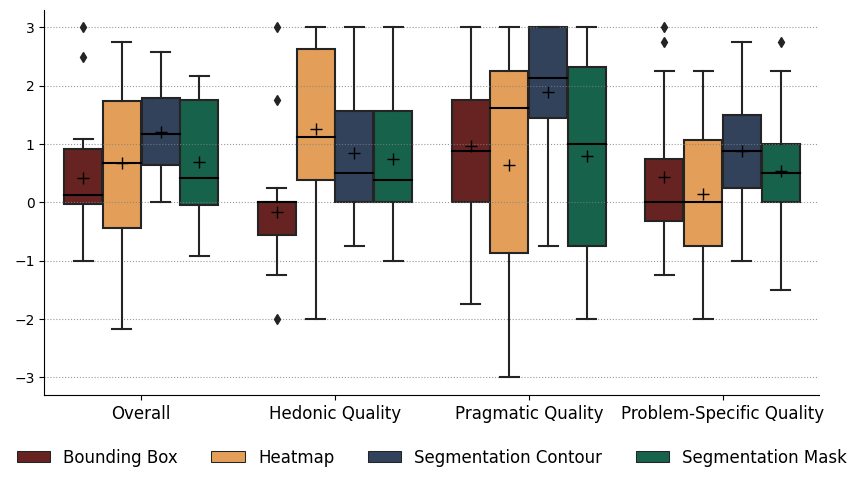

In [123]:
fig, ax = plt.subplots(figsize=(10, 5))

width = 0.8
sns.boxplot(plotting_df,  x='ux_quality', y='value_tf', hue='vis_type', ax=ax, width=width, showmeans=True,
            meanline=False, meanprops={'marker': '+', 'markeredgecolor': 'black', 'markersize': 8},
            medianprops={'color': 'black'})

ax.set_xlabel('')
ax.set_ylabel('')
ax.yaxis.grid(True, linestyle='dotted', alpha=0.8, c='grey')


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          frameon=False, ncol=4, fontsize=12)


ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.savefig('figures/qualities_boxplot.svg', bbox_inches='tight', dpi=200)
plt.show()

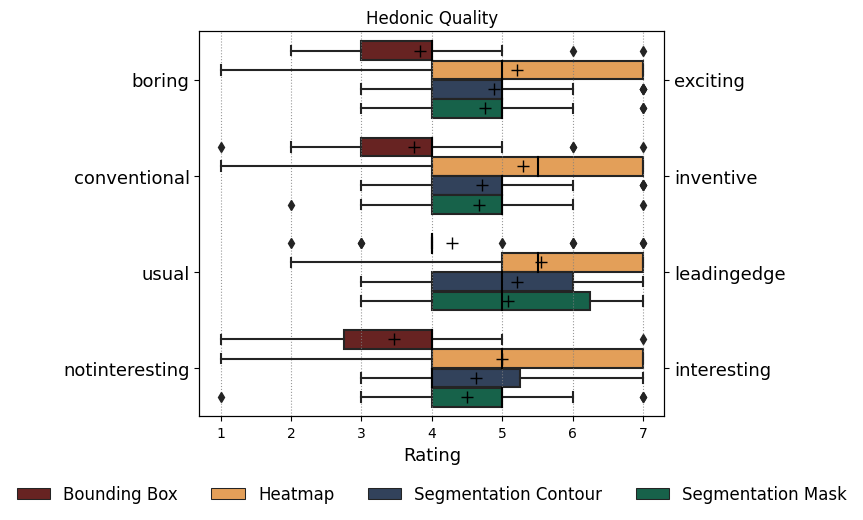

In [124]:
lower = [k.split('_')[0] for k, v in ux_hash.items() if v == 'Hedonic Quality' ]
upper = [k.split('_')[1] for k, v in ux_hash.items() if v == 'Hedonic Quality' ]

fig, ax = plt.subplots(figsize=(6, 5))

sns.boxplot(
    df_long.query('ux_quality == "Hedonic Quality"').sort_values(by=['vis_type', 'variable']),
    x='value', 
    y='variable', 
    hue='vis_type', 
    ax=ax,
    showmeans=True,
    meanline=False, meanprops={'marker': '+', 'markeredgecolor': 'black', 'markersize': 8},
    medianprops={'color': 'black'})

ax.set_xlabel('Rating', fontsize=13)
ax.set_ylabel('')

ax.set_yticklabels(lower, fontsize=13)

ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels(upper,fontsize=13)
ax.xaxis.grid(True, linestyle='dotted', alpha=0.8, c='grey')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14),
          frameon=False, ncol=4, fontsize=12)

ax.set_title('Hedonic Quality')

plt.savefig('figures/qualities_hedonic.svg', bbox_inches='tight', dpi=200)

plt.show()

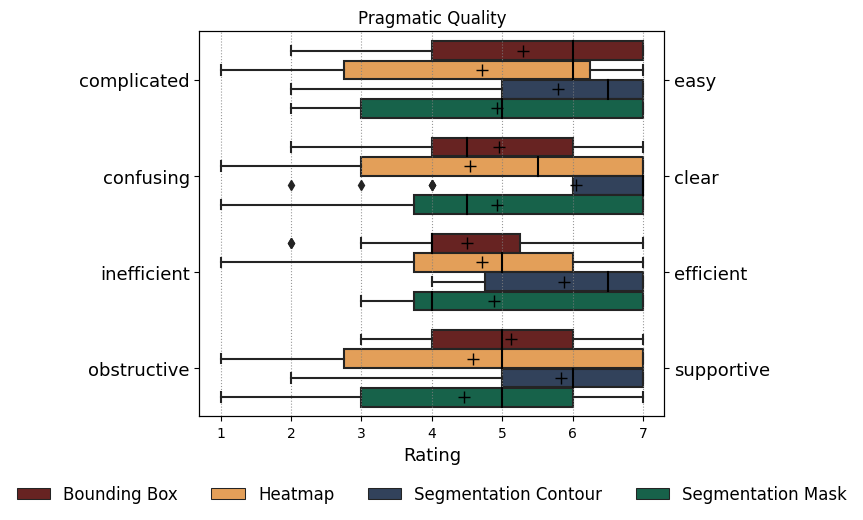

In [125]:
lower = [k.split('_')[0] for k, v in ux_hash.items() if v == 'Pragmatic Quality' ]
upper = [k.split('_')[1] for k, v in ux_hash.items() if v == 'Pragmatic Quality' ]

fig, ax = plt.subplots(figsize=(6, 5))

sns.boxplot(
    df_long.query('ux_quality == "Pragmatic Quality"').sort_values(by=['vis_type', 'variable']),
    x='value', 
    y='variable', 
    hue='vis_type', 
    ax=ax,
    showmeans=True,
    meanline=False, meanprops={'marker': '+', 'markeredgecolor': 'black', 'markersize': 8},
    medianprops={'color': 'black'})


ax.set_xlabel('Rating', fontsize=13)
ax.set_ylabel('')

ax.set_yticklabels(lower, fontsize=13)

ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels(upper,fontsize=13)
ax.xaxis.grid(True, linestyle='dotted', alpha=0.8, c='grey')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14),
          frameon=False, ncol=4, fontsize=12)


ax.set_title('Pragmatic Quality')

plt.savefig('figures/qualities_pragmatic.svg', bbox_inches='tight', dpi=200)
plt.show()

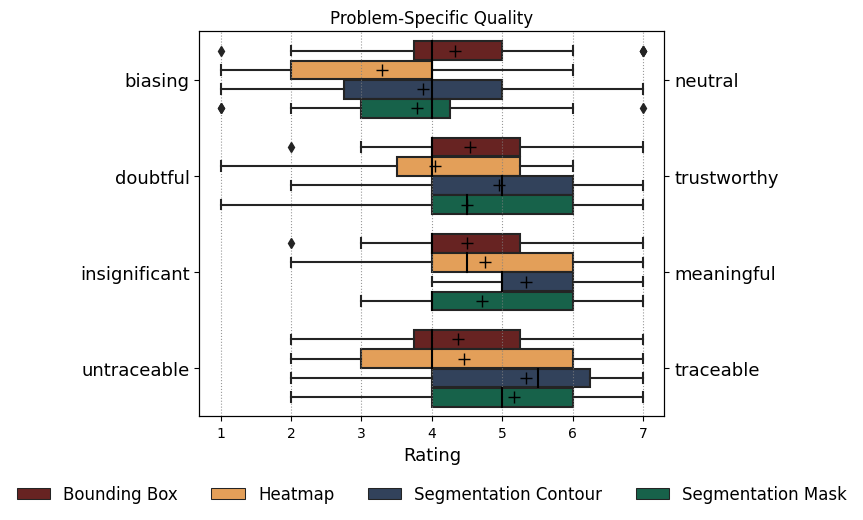

In [126]:
lower = [k.split('_')[0] for k, v in ux_hash.items() if v == 'Problem-Specific Quality' and k not in to_drop]
upper = [k.split('_')[1] for k, v in ux_hash.items() if v == 'Problem-Specific Quality' and k not in to_drop]

fig, ax = plt.subplots(figsize=(6, 5))

sns.boxplot(
    df_long.query('ux_quality == "Problem-Specific Quality"').sort_values(by=['vis_type', 'variable']),
    x='value', 
    y='variable', 
    hue='vis_type', 
    ax=ax,
    showmeans=True,
    meanline=False, meanprops={'marker': '+', 'markeredgecolor': 'black', 'markersize': 8},
    medianprops={'color': 'black'})

ax.set_xlabel('Rating', fontsize=13)
ax.set_ylabel('')

ax.set_yticklabels(lower, fontsize=13)

ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels(upper,fontsize=13)
ax.xaxis.grid(True, linestyle='dotted', alpha=0.8, c='grey')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14),
          frameon=False, ncol=4, fontsize=12)

ax.set_title('Problem-Specific Quality')

plt.savefig('figures/qualities_problem_specific.svg', bbox_inches='tight', dpi=200)
plt.show()